In [ ]:
import jax, jax.numpy as jnp

print("JAX:", jax.__version__)
import jaxlib
print("jaxlib:", jaxlib.__version__)
print("devices:", jax.devices())

# Test on CPU only:
cpu = jax.devices("cpu")[0]
with jax.default_device(cpu):
    print(jnp.arange(5, dtype=jnp.float64))

# Test on default device (likely Metal):
print(jnp.arange(5, dtype=jnp.float64))


In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import scipy.optimize
#import numpy as np
import matplotlib.pyplot as plt


## Auxillary function declarations 

In [2]:
def newton(f, x_0, rtol=1e-10, atol=1e-12, max_iter=50):
    """
    Multivariate Newton method with relative error control.
    """
    x = x_0
    f_jac = jax.jacobian(f)

    def newton_step(x):
        Fx = f(x)
        J  = f_jac(x)
        dx = jnp.linalg.solve(J, Fx)
        return x - dx, dx, Fx

    newton_step = jax.jit(newton_step, device=cpu)

    for n in range(1, max_iter + 1):
        x_new, dx, Fx = newton_step(x)

        step_norm = jnp.linalg.norm(dx)
        x_norm    = jnp.linalg.norm(x)
        res_norm  = jnp.linalg.norm(Fx)

        print(
            f"iter {n}: "
            f"step = {step_norm:.3e}, "
            f"residual = {res_norm:.3e}"
        )

        # Relative + absolute step criterion
        if step_norm <= atol + rtol * max(1.0, x_norm):
            return x_new

        x = x_new

    raise RuntimeError("Max iteration reached without convergence")

In [3]:
# --- flux components ---
def h_xxx(h, dx):
    """Third derivative (periodic)"""
    return (
        jnp.roll(h, -1)
        - 3.0 * h
        + 3.0 * jnp.roll(h, 1)
        - jnp.roll(h, 2)
    ) / dx**3


def f(h, eps):
    h = jnp.maximum(h, 0.0)
    h35 = h**3 * jnp.sqrt(h)   
    return h**4 / (eps + h35)


def a_gs(s1, s2, eps):
    s = 0.5 * (s1 + s2)
    return f(s, eps)


def da_gs(s1, s2, eps):
    s = jnp.maximum(s1 + s2, 0.0)
    s35 = s**3 * jnp.sqrt(s)
    num = 0.5 * s**3 * (4.0 * eps + 0.5 * s35)
    den = (eps + s35)**2
    return num / den



def a_eds(s1, s2, eps):
    h1 = jnp.maximum(s1, 0.0)
    h2 = jnp.maximum(s2, 0.0)

    Gp1 = 2.0 * jnp.sqrt(h1) - eps / (3.0 * h1**3)
    Gp2 = 2.0 * jnp.sqrt(h2) - eps / (3.0 * h2**3)

    num = h1 - h2
    den = Gp1 - Gp2

    # fallback when h1 ~ h2
    a_diag = f(h1, eps)

    return jnp.where(jnp.abs(den) > 1e-14, num / den, a_diag)


# --- Diff schemes ---

@jax.jit
def GS(h, h_curr, dx, dt, eps):
    h_f1 = jnp.roll(h, -1)
    h_b1 = jnp.roll(h, 1)

    f_f12 = a_gs(h,    h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_gs(h_b1, h,    eps) * h_xxx(h,    dx)

    return h - h_curr + (dt / dx) * (f_f12 - f_b12)


@jax.jit
def EDS(h, h_curr, dx, dt, eps):
    h_f1 = jnp.roll(h, -1)
    h_b1 = jnp.roll(h, 1)

    f_f12 = a_eds(h,    h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_eds(h_b1, h,    eps) * h_xxx(h,    dx)

    return h - h_curr + (dt / dx) * (f_f12 - f_b12)





--- Jacobian ---

def DGS(h, h_curr, dx, dt, eps):
    h_f1 = np.roll(h, -1)
    h_b1 = np.roll(h, 1)

    F_hb2 = (dt/dx) * a_gs(h_b1, h, eps) / dx**3
    F_hb1 = (dt/dx) * (a_gs(h, h_f1, eps)/dx**3 - da_gs(h_b1, h, eps) * h_xxx(h, dx) + 3*a_gs(h_b1, h, eps)/dx**3)
    F_h = 1 + (dt/dx) * (da_gs(h, h_f1, eps)*h_xxx(h_f1, dx) + 3*a_gs(h, h_f1, eps)/dx**3 - da_gs(h_b1,h, eps)*h_xxx(h, dx) + 3*a_gs(h_b1,h, eps)/dx**3)
    F_hf1 = (dt/dx) * (da_gs(h,h_f1, eps)*h_xxx(h_f1, dx) - 3*a_gs(h,h_f1, eps)/dx**3 - a_gs(h_b1,h, eps)/dx**3)
    F_hf2 = (dt/dx) * a_gs(h,h_f1, eps)/dx**3

    # Initialize Jacobian
    G = np.zeros((h_curr.shape[0], h_curr.shape[0]))

    # Fill stencil with modulo indexing for periodicity
    for i in range(h_curr.shape[0]):
        G[i, i] = F_h[i]
        G[i, (i-1)%N] = F_hb1[i]
        G[i, (i-2)%N] = F_hb2[i]
        G[i, (i+1)%N] = F_hf1[i]
        G[i, (i+2)%N] = F_hf2[i]

    return G

## Fine grid simulations 

### Solution evolution using the generic scheme with large $\Delta t$

In [4]:
cpu = jax.devices("cpu")[0]


Metal device set to: Apple M5

systemMemory: 24.00 GB
maxCacheSize: 8.88 GB



W0000 00:00:1766712201.563120 3685688 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1766712201.576485 3685688 service.cc:145] XLA service 0x97b1c0500 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766712201.576494 3685688 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1766712201.577655 3685688 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1766712201.577664 3685688 mps_client.cc:384] XLA backend will use up to 19069206528 bytes on device 0 for SimpleAllocator.


In [5]:
N = 512
dx = float(1/N)
dt = float(1e-6)
eps = float(1e-11)

with jax.default_device(cpu):
    i = jnp.arange(N, dtype=jnp.int32)
    x = (-1.0 + (2.0 / N) * i).astype(jnp.float64)
    h0 = 0.8 - jnp.cos(jnp.pi * x) + 0.25 * jnp.cos(2.0 * jnp.pi * x)

In [6]:
h0_cpu = jax.device_put(h0, cpu)
jax_sol = newton(lambda h: GS(h, h0_cpu, dx, dt, eps), h0_cpu, rtol=1e-11, atol=1e-12, max_iter=50)

iter 1: step = 1.058e-01, residual = 1.107e-01
iter 2: step = 1.101e-05, residual = 1.969e-05
iter 3: step = 1.933e-10, residual = 1.422e-09


In [14]:
sol = scipy.optimize.root(lambda h: GS(h, h0_cpu, dx, dt, eps), h0_cpu, tol=1e-12)

In [16]:
jnp.max(jnp.abs(GS(sol.x, h0_cpu, dx, dt, eps)))

Array(2.88056344e-10, dtype=float64)

In [17]:
jnp.max(jnp.abs(GS(jax_sol, h0_cpu, dx, dt, eps)))

Array(2.38595528e-10, dtype=float64)

In [7]:
K = 500
h_curr = h0_cpu

for k in range(K):

    if k % 1000 == 0:
        print(f"Iter {k}")


    F = lambda h: GS(h, h_curr, dx, dt, eps)

    h_next = newton(F, h_curr, rtol=1e-11, atol=1e-12)

    h_curr = h_next

Iter 0
iter 1: step = 1.058e-01, residual = 1.107e-01
iter 2: step = 1.101e-05, residual = 1.969e-05
iter 3: step = 1.933e-10, residual = 1.422e-09
iter 1: step = 1.014e-01, residual = 1.058e-01
iter 2: step = 9.943e-06, residual = 1.707e-05
iter 3: step = 1.631e-10, residual = 1.396e-09
iter 1: step = 9.754e-02, residual = 1.014e-01
iter 2: step = 9.081e-06, residual = 1.507e-05
iter 3: step = 1.612e-10, residual = 1.414e-09
iter 1: step = 9.408e-02, residual = 9.754e-02
iter 2: step = 8.389e-06, residual = 1.354e-05
iter 3: step = 8.905e-11, residual = 1.277e-09
iter 1: step = 9.094e-02, residual = 9.408e-02
iter 2: step = 7.827e-06, residual = 1.238e-05
iter 3: step = 5.941e-11, residual = 1.183e-09
iter 1: step = 8.807e-02, residual = 9.094e-02
iter 2: step = 7.364e-06, residual = 1.149e-05
iter 3: step = 8.177e-11, residual = 1.207e-09
iter 1: step = 8.544e-02, residual = 8.807e-02
iter 2: step = 6.970e-06, residual = 1.079e-05
iter 3: step = 2.185e-10, residual = 1.349e-09
iter 1

RuntimeError: Max iteration reached without convergence

In [10]:
N = 512
dx = 1/N
dt = 1e-6
eps = 1e-7

x = np.linspace(-1, 1, N, endpoint=False)
K = 50000
h0 = 0.8 - np.cos(np.pi*x) + 0.25 * np.cos(2 * np.pi * x)

sampling_iters = [999, 1999, 4999, 7999, 15999, 31999, 49999]
sampled_sol = []

h_curr = h0

for k in range(K):
    if k == 50000:
        dt = 1e-4
    #print("Iter", k)
    if  k % 1000 == 0:
        print("Iter", k)
    sol = scipy.optimize.root(GS, h_curr, args=(h_curr, dx, dt, eps))
    if sol.success:
        h_curr = sol.x
    else:
        print("Trying a spectral residual method")
        sol = scipy.optimize.root(GS, h_curr, args=(h_curr, dx, dt, eps), method="df-sane")
        if sol.success:
            h_curr = sol.x
        else:
            print(f"Still cannot resolve the instability at Iter {k}")
            break

    if k in sampling_iters:
        sampled_sol.append(h_curr)

NameError: name 'np' is not defined

3.377658014782858e-05
1.585291281948907


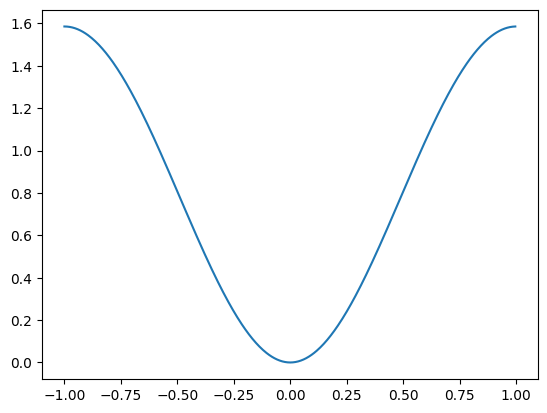

In [10]:
plt.plot(x, h_curr)
print(jnp.min(jnp.abs(h_curr)))
print(jnp.max(jnp.abs(h_curr)))

In [ ]:
plt.figure()
plt.plot(x, h0, label="t = 0")

for i in range(len(sampled_sol)):
    t = (sampling_iters[i] + 1) * 1e-6
    plt.plot(x, sampled_sol[i], label=f"t = {t}")

plt.xlabel("$x$")
plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-7}$")
plt.legend()
plt.savefig("sim_results.png", dpi = 200)

In [ ]:
N = 128
dx = 1/N
dt = 1e-5
eps = 1e-7

x = np.linspace(-1, 1, N, endpoint=False)
K = 5460
h0 = 0.8 - np.cos(np.pi*x) + 0.25 * np.cos(2 * np.pi * x)

sampling_iters = [999, 1999, 4999, 5039, 5119, 5279, 5460]
sampled_sol = []

h_curr = h0

for k in range(100):
    if k == 5000:
        dt = 1e-4
    #print("Iter", k)
    #if  k % 100 == 0:
    #    print("Iter", k)
    sol = scipy.optimize.root(EDS, h_curr, args=(h_curr, dx, dt, eps))
    if sol.success:
        h_curr = sol.x
    else:
        print("Trying a spectral residual method")
        sol = scipy.optimize.root(EDS, h_curr, args=(h_curr, dx, dt, eps), method="df-sane")
        if sol.success:
            h_curr = sol.x
        else:
            print(f"Still cannot resolve the instability at Iter {k}")
            break

    if k in sampling_iters:
        sampled_sol.append(h_curr)

In [ ]:
plt.plot(x, h_curr)